In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
from mpl_toolkits.mplot3d import Axes3D
import planet_data as pd

In [29]:
class orbitPropagator:
    def __init__(self,r0, v0,tspan, dt, cb = pd.earth ):
        self.r0 = r0
        self.v0 = v0
        self.tspan = tspan
        self.dt = dt
        self.cb = cb
    def propagate_orbit(self):
        #total number of steps
        self.n_steps = int(np.ceil(self.tspan/self.dt))

        #initialize arrays
        self.ys = np.zeros((self.n_steps, 6))
        self.ts = np.zeros((self.n_steps, 1))

        #initial conditions
        self.y0  = self.r0+self.v0
        self.ys[0] = np.array(self.y0)
        self.step=1

        #initialize solver
        self.solver = ode(self.diff_eqn)
        self.solver.set_integrator('lsoda')
        self.solver.set_initial_value(self.y0, 0)


        #propogate orbit
        while self.solver.successful() and self.step< self.n_steps:
            self.solver.integrate(self.solver.t+self.dt)
            self.ts[self.step] =  self.solver.t
            self.ys[self.step] = self.solver.y
            self.step+=1
        self.rs = self.ys[:,:3]
        self.vs = self.ys[:,3:]
    
    def diff_eqn(self, t, y):
        # unpack the state
        rx, ry, rz, vx, vy, vz = y
        r = np.array([rx, ry, rz])

        #norm of radius vector
        norm_r = np.linalg.norm(r)

        #two body acceleration
        ax, ay, az = -r*self.cb['mu']/norm_r**3

        return [vx,vy,vz, ax, ay, az]
    
    def plot3d (self, show_plot = False ,save_plot = False ):
        fig=plt.figure(figsize=(18,6))
        ax = fig.add_subplot(111, projection='3d')
        # plot trajectory
        ax.plot(self.rs[:,0], self.rs[:,1], self.rs[:,2], 'k', label = 'trajectory')
        ax.plot([self.rs[0,0]], [self.rs[0,1]], [self.rs[0,2]], 'k*', label = 'initial position')

        #plot central body
        _u, _v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        _x = self.cb['radius']*np.cos(_u)*np.sin(_v)
        _y = self.cb['radius']*np.sin(_u)*np.sin(_v)
        _z = self.cb['radius']*np.cos(_v)
        ax.plot_surface(_x,_y,_z, cmap = "Blues")

        #plot x, y, z, vectors
        l = self.cb['radius']*2
        x,y,z = [[0,0,0], [0,0,0], [0,0,0]]
        u,v,w = [[1,0,0], [0,1,0], [0,0,1]]
        ax.quiver(x,y,z,u,v,w,color='k')

        max_val = np.max(np.abs(self.rs))

        ax.set_xlim([-max_val, max_val])
        ax.set_ylim([-max_val, max_val])
        ax.set_zlim([-max_val, max_val])

        ax.set_xlabel(['X (km)'])
        ax.set_ylabel(['Y (km)'])
        ax.set_zlabel(['Z (km)'])

        #ax.set_aspect('equal')

        ax.set_title('Two Body Visual')
        plt.legend(['Trajectory', 'Initial Position'])
        for ii in range(0,360,1):
            ax.view_init(elev=270,azim=ii)
        if show_plot:
            plt.show()
        if save_plot:
            plt.savefig('Two body'+'.png', dpi = 300)

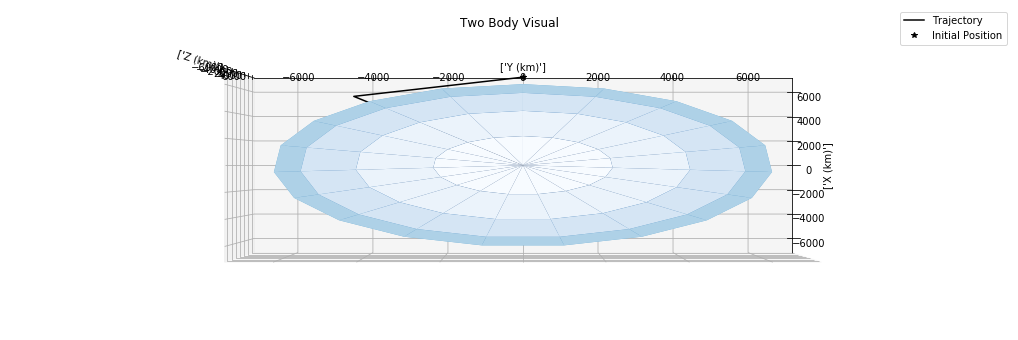

In [30]:
cb = pd.earth
if __name__ == '__main__':
    #initial condition of orbit parameters
    r_mag = cb['radius'] +500 #km
    v_mag = np.sqrt(cb['mu']/r_mag) #km/s
    
    #initial position and velocity vectors
    r0 = [r_mag, 0,0]
    v0 = [0, v_mag, 0]
    
    #timespane
    tspan = 6*3600*24.0
    
    #timestep
    dt = 100.0
    
    op = orbitPropagator(r0, v0, tspan, dt)
    op.propagate_orbit()
    op.plot3d(show_plot = True)